
# **Tutorial on Causality**
## TACsy PhD School 2025
### Date: February 19, 2025 <br>
### Lecturer: Adèle Helena Ribeiro

## Setup



In [1]:
%load_ext rpy2.ipython

In [2]:
!apt-get install librsvg2-dev > /dev/null 2>&1



In [3]:
%ls "/usr/local/lib/R/site-library/"

abind/         clue/         graph/        lmtest/      pbivnorm/       rgl/          V8/
ape/           corpcor/      htmlwidgets/  __MACOSX/    pcalg/          Rgraphviz/    vcd/
bdsmatrix/     dagitty/      huge/         markdown/    quadprog/       R.methodsS3/  vdiffr/
BH/            decor/        igraph/       matrixcalc/  RBGL/           robustbase/   XML/
BiocGenerics/  DEoptimR/     igraphdata/   mnormt/      R.cache/        R.oo/         zoo/
BiocManager/   DOT/          IRdisplay/    mvtnorm/     Rcpp/           R.rsp/
BiocVersion/   fastDummies/  IRkernel/     numDeriv/    RcppArmadillo/  rsvg/
causaleffect/  fastICA/      jsonlite/     PAGId/       RcppEigen/      R.utils/
CCP/           ggm/          lavaan/       pbdZMQ/      repr/           sfsmisc/


In [4]:
!wget -c https://github.com/adele/Causality-Tutorial/raw/refs/heads/main/resources/Rpackages.zip -O Rpackages.zip
!file *.zip
!unzip -n Rpackages.zip -d /usr/local/lib/R/site-library/ > /dev/null 2>&1

--2025-02-17 19:46:44--  https://github.com/adele/Causality-Tutorial/raw/refs/heads/main/resources/Rpackages.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adele/Causality-Tutorial/refs/heads/main/resources/Rpackages.zip [following]
--2025-02-17 19:46:44--  https://raw.githubusercontent.com/adele/Causality-Tutorial/refs/heads/main/resources/Rpackages.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Rpackages.zip: Zip archive data, at least v2.0 to extract, compression method=store


In [5]:
%ls "/usr/local/lib/R/site-library/"

abind/         clue/         graph/        lmtest/      pbivnorm/       rgl/          V8/
ape/           corpcor/      htmlwidgets/  __MACOSX/    pcalg/          Rgraphviz/    vcd/
bdsmatrix/     dagitty/      huge/         markdown/    quadprog/       R.methodsS3/  vdiffr/
BH/            decor/        igraph/       matrixcalc/  RBGL/           robustbase/   XML/
BiocGenerics/  DEoptimR/     igraphdata/   mnormt/      R.cache/        R.oo/         zoo/
BiocManager/   DOT/          IRdisplay/    mvtnorm/     Rcpp/           R.rsp/
BiocVersion/   fastDummies/  IRkernel/     numDeriv/    RcppArmadillo/  rsvg/
causaleffect/  fastICA/      jsonlite/     PAGId/       RcppEigen/      R.utils/
CCP/           ggm/          lavaan/       pbdZMQ/      repr/           sfsmisc/


### Installing additional required packages

In [6]:
%%R
suppressWarnings(install.packages('rsvg', verbose=FALSE))


(as ‘lib’ is unspecified)







	‘/tmp/RtmpAyzXB3/downloaded_packages’



### Loading libraries

In [7]:
%%R

library(pcalg, warn.conflicts=F, quietly=T)
library(dagitty, warn.conflicts=F, quietly=T)
library(MASS, warn.conflicts=F, quietly=T)
library(causaleffect, warn.conflicts=F, quietly=T)
library(igraph, warn.conflicts=F, quietly=T)
library(DOT, warn.conflicts=F, quietly=T)
library(devtools, warn.conflicts=F, quietly=T)
library(rsvg, warn.conflicts=F, quietly=T)

### Helper Functions

In [8]:
%%R

####################
# Helper Functions #
####################

# A <- f(Ua) = Ua
# D <- f(Ucd, Ud) = beta_D.Ucd * Ucd + Ud
# B <- f(A, D, Ub) = beta_B.A * A - beta_B.D * D + Ub
# C <- f(Ucd, B, Uc) = beta_C.B * B - beta_C.Ucd * Ucd + Uc
# betaList is a list with entries for:
# beta_D.Ucd, beta_B.A, beta_B.D, beta_C.Ucd, and beta_C.B
# if betaList is NULL, then coefficients are randomly selected
getIVSEM <- function(betaList=NULL) {
  allvars <- c("A", "B", "C", "D", "Ucd")
  p <- length(allvars)
  beta <- matrix(0, p, p)
  colnames(beta) <- rownames(beta) <- allvars
  topolOrd <- c( "Ucd", "A", "D", "B", "C")

  if (is.null(betaList)) {
    betaList <- as.list(sample(c(-1, 1), p, replace = T) * runif(p, 0.3, 0.7))
    names(betaList) <- c("beta_D.Ucd", "beta_B.A", "beta_B.D", "beta_C.Ucd", "beta_C.B")
  }

  beta["Ucd","D"] <- betaList$beta_D.Ucd; # coeff of Ucd in the function for d
  beta["A", "B"] <- betaList$beta_B.A; # coeff of a in the function for b
  beta["D", "B"] <- betaList$beta_B.D; # coeff of d in the function for b
  beta["Ucd", "C"] <- betaList$beta_C.Ucd; # coeff of Ucd in the function for c
  beta["B", "C"] <- betaList$beta_C.B; # coeff of b in the function for c

  # Note that beta is triangular, implying that the SEM is recursive (or acyclic)
  beta <- beta[topolOrd, topolOrd]
  lat <- c("Ucd")

  return(list(beta=beta, lat=lat))
}

# A -> B -> C; B <- D <- Ucd -> C
getIVGraph <- function() {
  allvars <- c("A", "B", "C", "D", "Uab", "Ucd")
  p <- length(allvars)
  amat <- matrix(0, p, p)
  colnames(amat) <- rownames(amat) <- allvars
  amat["Uab","A"] <- 0; amat["A","Uab"] <- 1; # Uab -> a
  amat["Uab","B"] <- 0; amat["B","Uab"] <- 1; # Uab -> b
  amat["B","C"] <- 0; amat["C","B"] <- 1; # b -> c
  amat["D","B"] <- 0; amat["B","D"] <- 1; # d -> b
  amat["Ucd","C"] <- 0; amat["C","Ucd"] <- 1; # Ucd -> c
  amat["Ucd","D"] <- 0; amat["D","Ucd"] <- 1; # Ucd -> c

  lat <- c("Uab", "Ucd")
  adag <- pcalg::pcalg2dagitty(amat, colnames(amat), type="dag")
  dagitty::latents(adag) <- lat
  coordinates(adag) <- list( x=c(A=0.5, Uab=0.65, B=0.80, C=1, D=0.88, Ucd=1),
                        y=c(A=0.15, Uab=0.05, B=0.15, C=0.15, D=0, Ucd=0) )


  idag <- igraph_from_graphNel(as(t(amat), "graphNEL"), lat)

  return(list(amat.dagitty = adag, # adjacency matrix as a dagitty object
              amat.igraph = idag, # adjacency matrix as an igraph object
              amat.pcalg = amat  # adjacency matrix as a matrix using pcalg notation
              ))
}

# The SEM is constructed as
# Y = B Y + eps, where B == beta
# beta is a matrix of the coefficients for all variables (V and U)
# Y = BY + eps --> Y - BY = eps --> (I - B)Y = eps --> Y = (I -B)^{-1} eps
generateDatasetFromSEM <- function(beta, lat, N) {
  p <- ncol(beta)
  ident <- diag(1, p, p)
  colnames(ident) <- rownames(ident) <- colnames(beta)
  # Or, similarly,
  # Y = (I - Beta)^{-1} eps.
  # For Gaussian Y and errors eps independent from each other (we have all the Us),
  # we just need to simulate Y from a multivariate distribution
  # of mean zero and cov Sigma=I
  IminusBinv <- ginv(ident - beta)
  Sigma = t(IminusBinv) %*% ident %*% IminusBinv

  valR <- matrixcalc::is.symmetric.matrix(Sigma) &&
    matrixcalc::is.positive.definite(Sigma, tol=1e-8)
  if (!valR) {
    stop("This SEM generates a non-positive definite covariance matrix. Try another SEM.")
  }

  dat <-  MASS::mvrnorm(N, rep(0, p), Sigma, empirical = FALSE)
  dat <- as.data.frame(dat)
  colnames(dat) <- colnames(beta)
  head(dat)

  uvars <- which(colnames(dat) %in% lat)
  dat <- dat[,-uvars]

  return(dat)
}

# Randomly generate a linear SEM following a dagitty DAG, adag,
# and then draw samples from it.
generateDatasetFromDAG <- function(adag, N, ntries=30) {
  done <- FALSE
  tries <- 0
  obs.dat <- NULL
  while (!done && tries <= ntries) {
    done <- tryCatch(
      {
        obs.dat <- dagitty::simulateSEM(adag, b.lower = -0.6, b.upper = 0.6, N=N)
        R <- cor(obs.dat)
        valR <- matrixcalc::is.symmetric.matrix(R) &&
          matrixcalc::is.positive.definite(R, tol=1e-8)
        valR
      }, error=function(cond) {
        message(cond)
        FALSE
      })
    tries <- tries + 1
  }
  return(obs.dat)
}

dagittyOracleCI <- function(x, y, S, suffStat) {
  g <- suffStat$g
  labels <- names(g)
  if (dagitty::dseparated(g, labels[x], labels[y], labels[S])) {
    return(1)
  } else {
    return(0)
  }
}

# receives a dagitty g of type "dag" or "mag" and returns
# the true PAG as an pcalg fci object
getTruePAG <- function(g, verbose = FALSE) {
  indepTest <- dagittyOracleCI
  if (graphType(g) == "dag") {
    g <- dagitty::toMAG(g)
  }
  suffStat <- list(g=g)
  truePag <- pcalg::fci(suffStat,
                        indepTest = indepTest,
                        labels= names(suffStat$g), alpha = 0.9999,
                        verbose = verbose)
  return(truePag)
}



# n: number of nodes
# e_prob: probability of having an edge between any two nodes
# l_prob: proportion of the nodes to be considered latent (unmeasured variables)
getRandomGraph <- function(n, e_prob, l_prob, force_nedges=TRUE)  {
  if (force_nedges) {
    min_nedges <- floor((n*(n-1)/2)*(e_prob * 1))
  } else {
    min_nedges <- 0
  }
  nedges <- 0
  while (nedges <= min_nedges) {
    dag <- pcalg::randomDAG(n, e_prob, V = paste0("V", sprintf(
      paste0("%0", nchar(n), "d"), seq(from = 1, to = n))))

    amat.dag <- (as(dag, "matrix") > 0) * 1
    adag <- pcalg::pcalg2dagitty(amat.dag, colnames(amat.dag), type="dag")
    lat <- sample(colnames(amat.dag), l_prob * n)

    dagitty::latents(adag) <- lat

    magg <- dagitty::toMAG(adag)
    nedges <- nrow(edges(magg))
  }

  return(adag)
}

renderDAG <- function(amat, output_folder=NULL, fileid=NULL, type="png",
                     width=NULL, height=NULL, labels=NULL, add_index=TRUE) {
  amat.ag <- amat
  for (i in 1:ncol(amat.ag )) {
      for (j in 1:(ncol(amat.ag ))) {
          if (amat.ag [i,j] == 1 && amat.ag [j, i] == 0) {
              # j -> i
              amat.ag [j,i] <- 2
              amat.ag [i,j] <- 3
          }
      }
  }
  renderAG(amat.ag, output_folder, fileid, type, width, height, labels,
           add_index)
}

# types can be: png, pdf, or svg
#' @importFrom rsvg rsvg_png
#' @importFrom DOT dot
#' @export renderAG
renderAG <- function(amat, output_folder=NULL, fileid=NULL, type="png",
                     width=NULL, height=NULL, labels=NULL, add_index=TRUE) {
  if (is.null(labels)) {
    labels <- colnames(amat)
  }

  if (is.null(output_folder)) {
    output_folder = "./tmp/"
  }

  if (!file.exists(output_folder)) {
    dir.create(output_folder, recursive = TRUE)
  }

  if (is.null(fileid)) {
    fileid <- "ag"
  }

  if (type == "png") {
    png_filename <- paste0(output_folder, fileid, ".png")
    if (is.null(width)) {
      width = 1024
    }
    if (is.null(height)) {
      height = 1024
    }
  } else if (type == "pdf") {
    pdf_filename <- paste0(output_folder, fileid, ".pdf")
    if (is.null(width)) {
      width = 5
    }
    if (is.null(height)) {
      height = 5
    }
  }

  dot_filename <- paste0(output_folder, fileid, ".dot")
  svg_filename <- paste0(output_folder, fileid, ".svg")

  graphFile <- file(dot_filename, "w")
  cat('digraph graphname {', file=graphFile)
  cat('node [shape = oval];\n', file=graphFile)

  formatted_labels <- labels
  if (add_index) {
    formatted_labels <- paste0(formatted_labels, "_", 1:length(labels))
  }

  for (v in formatted_labels) {
    cat(v, "[label=", v, "]\n", file=graphFile)
  }

  # For each row:
  for (i in 1:(nrow(amat)-1)) {
    # For each column:
    for (j in (i+1):ncol(amat)) {
      label_i <- formatted_labels[i]
      label_j <- formatted_labels[j]

      if (amat[i,j] > 0) {
        cat(label_i, "->", label_j, "[color=black, dir=both,",  file=graphFile)
        if (amat[i,j] == 1) {
          cat("arrowhead=odot, ", file=graphFile)
        } else if (amat[i,j] == 2) {
          cat("arrowhead=normal, ", file=graphFile)
        } else if (amat[i,j] == 3) {
          cat("arrowhead=none, ", file=graphFile)
        }

        if (amat[j,i] == 1) {
          cat("arrowtail=odot", file=graphFile)
        } else if (amat[j,i] == 2) {
          cat("arrowtail=normal", file=graphFile)
        } else if (amat[j,i] == 3) {
          cat("arrowtail=none", file=graphFile)
        }
        cat("];\n", file=graphFile)
      }
    }
  }
  cat("}\n", file=graphFile)
  close(graphFile)

  DOT::dot(paste(readLines(dot_filename), collapse=" "), file=svg_filename)

  if (type == "png") {
    rsvg::rsvg_png(svg_filename, png_filename, width = 1024, height = 1024)
  } else if (type == "pdf") {
    rsvg::rsvg_pdf(svg_filename, pdf_filename, width = 5, height = 5)
  }
}

igraph_from_graphNel <- function(graphN, latNodes){
  igraph_dag <- igraph::igraph.from.graphNEL(graphN, weight = FALSE)
  for (n in latNodes) {
    adj_list <- graphN@edgeL[[n]]$edges
    if (length(adj_list) == 2) {
      igraph_dag <- igraph::add_edges(igraph_dag, c(adj_list[1], adj_list[2], adj_list[2], adj_list[1]))
      igraph_dag <- igraph::set.edge.attribute(graph = igraph_dag,
                                               name ="description",
                                               index = c(length(igraph::E(igraph_dag))-1, length(igraph::E(igraph_dag))), value = "U")
    }
  }
  for (n in latNodes){
    igraph_dag <- igraph::delete_vertices(igraph_dag, n)
  }
  return(igraph_dag)
}

# returns an pcalg amat (adjacency matrix) of
# type amat.pag (same type for MAGs), where:
# 0: No edge
# 1: Circle
# 2: Arrowhead
# 3: Tail
dagitty2amat <- function(adagg, type="mag") {
  edg <- dagitty:::edges(adagg)
  node_names <- dagitty:::names.dagitty(adagg)
  ans_mat <- matrix(
    data = 0, nrow = length(node_names),
    ncol = length(node_names),
    dimnames = list(node_names, node_names)
  )

  diredg <- subset(edg, e == "->")

  ans_mat[as.matrix(diredg[c("w", "v")])] <- 3
  ans_mat[as.matrix(diredg[c("v", "w")])] <- 2

  bidiredg <-  subset(edg, e == "<->")
  ans_mat[as.matrix(bidiredg[c("w", "v")])] <- 2
  ans_mat[as.matrix(bidiredg[c("v", "w")])] <- 2

  return(ans_mat)
}



## **Part I: Causal Modeling**

In [9]:
%%R
# Defining true underlying model -- typically unknown

# A -> B -> C; B <- D <- Ucd -> C

allvars <- c("A", "B", "C", "D", "Uab", "Ucd")
p <- length(allvars)
amat <- matrix(0, p, p)
colnames(amat) <- rownames(amat) <- allvars
amat["Uab","A"] <- 0; amat["A","Uab"] <- 1; # Uab -> a
amat["Uab","B"] <- 0; amat["B","Uab"] <- 1; # Uab -> b
amat["B","C"] <- 0; amat["C","B"] <- 1; # b -> c
amat["D","B"] <- 0; amat["B","D"] <- 1; # d -> b
amat["Ucd","C"] <- 0; amat["C","Ucd"] <- 1; # Ucd -> c
amat["Ucd","D"] <- 0; amat["D","Ucd"] <- 1; # Ucd -> c

# Adjacency Matrix
# print(amat)

# Generating DAG image
renderDAG(amat, fileid = "trueDAG", add_index = FALSE)

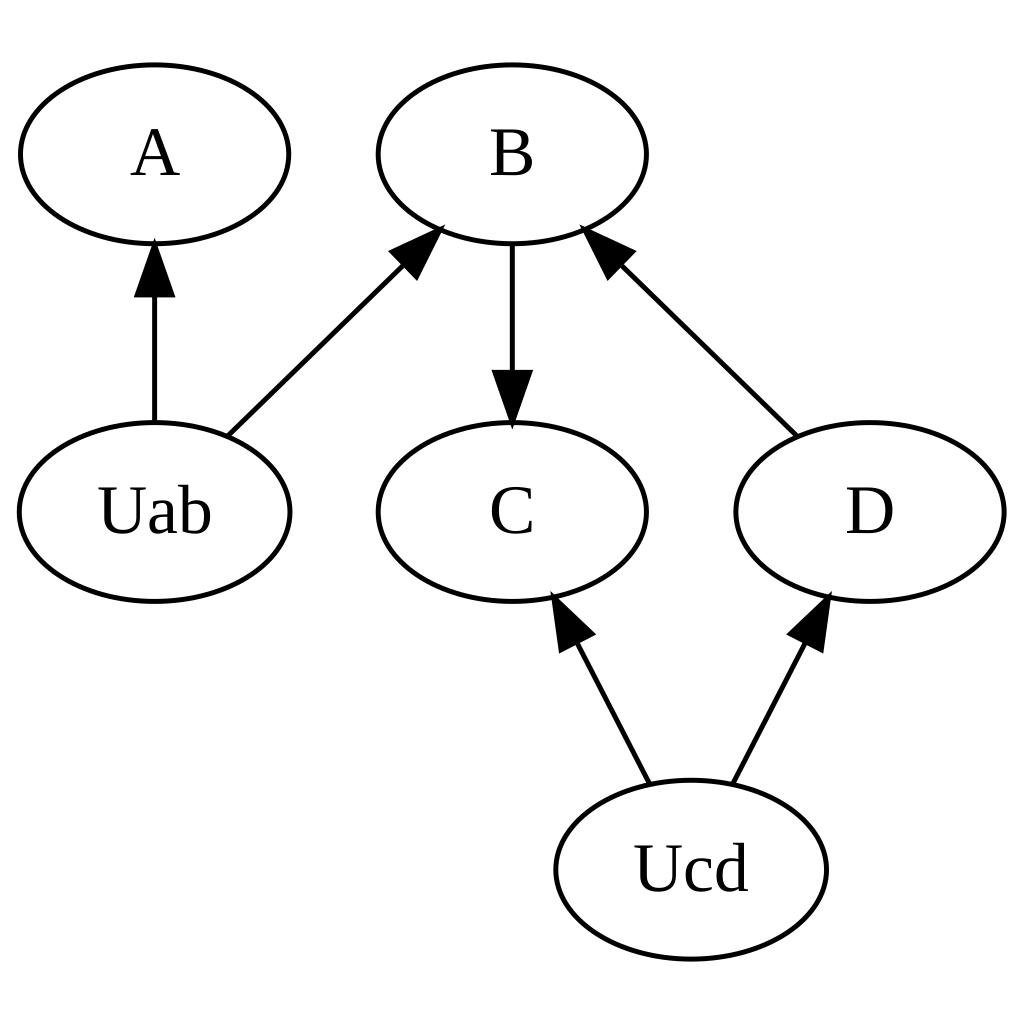

In [10]:
from IPython.display import Image
Image('tmp/trueDAG.png', width=400, height=400)

In [11]:
%%R

# Specifying our DAG as a dagitty object

lat <- c("Uab", "Ucd")
trueDAG <- pcalg::pcalg2dagitty(amat, colnames(amat), type="dag")
dagitty::latents(trueDAG) <- lat


# In case you want to plot using dagitty:
# coordinates(adag) <- list( x=c(A=0.5, Uab=0.65, B=0.80, C=1, D=0.88, Ucd=1),
#                      y=c(A=0.15, Uab=0.05, B=0.15, C=0.15, D=0, Ucd=0) )
# plot(trueDAG) # showing the U variables


# Specifying our DAG as a igraph object
trueDiagram <- igraph_from_graphNel(as(t(amat), "graphNEL"), lat)

## **Part II: Markov Equivalence Class**

#### Implied Conditional Independencies

The true causal diagram implies, through d-separations, all and only conditional independencies (among observed variables) implied by the true SCM.



In [12]:
%%R
trueMAG <- dagitty::toMAG(trueDAG)
trueImpliedCI <- dagitty::impliedConditionalIndependencies(trueMAG, type = "missing.edge")
trueImpliedCI

A _||_ C | B, D
A _||_ D


#### Partial Ancestral Graph (PAG)

A Partial Ancestral Graph (PAG) represents the class of all statistically equivalent causal models, i.e., those implying exactly the same set of conditional independencies.

In [13]:
%%R

truePAG <- getTruePAG(trueDAG, verbose = FALSE)

Plotting the true PAG

In [14]:
%%R

#plot(truePAG)
renderAG(truePAG@amat, fileid = "truePAG", add_index = FALSE)

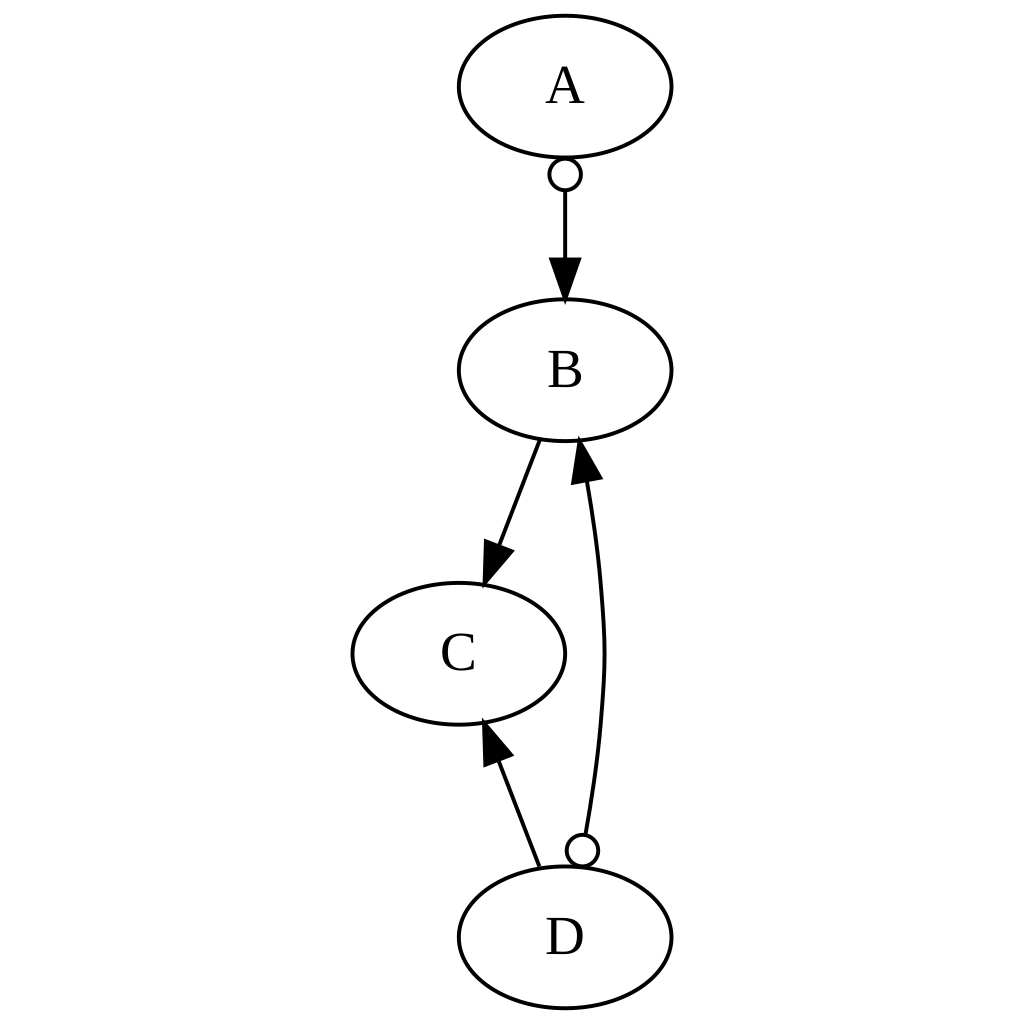

In [15]:
from IPython.display import Image
Image('tmp/truePAG.png', width=400, height=400)

## **Part III: Causal Discovery**

### Data Generation from the True Diagram

We are generating N=10000 samples.

In [16]:
%%R

seed <- sample(1:2^15, 1)
print(seed)

set.seed(17876) # Good for N = 50000

N = 50000
dat <- generateDatasetFromDAG(trueDAG, N)
head(dat) #

[1] 7615
            A          B           C          D
1  0.06803594  1.6212072  0.55572349  0.2907695
2 -0.18152229 -0.1968323 -0.58312688 -0.1395954
3 -0.24665251 -0.8222708 -0.61409294 -0.1019799
4  0.90324959  2.5861567  1.45709180  1.2517536
5 -1.11488461 -1.5108330 -1.58084231 -0.7343397
6 -0.46346801 -1.5011062 -0.01141822 -0.4476319


### Inferring the PAG using FCI Algorithm

Since our variables follow a Gaussian distribution, the partial correlation test (Fisher's Z test) can be used to assess conditional independencies.

For other data types, appropriate conditional independence tests should be used.


In [17]:
%%R

indepTest <- pcalg::gaussCItest    # Fisher's Z test
alpha <- 0.05                      # Significance level of 5%
suffStat <- list(C = cor(dat), n = N)
estPAG <- pcalg::fci(suffStat,
                     indepTest = indepTest,
                     labels= colnames(dat), alpha = alpha,
                     verbose = FALSE)
#plot(estPAG)
renderAG(estPAG@amat, fileid = "estimatedPAG", add_index = FALSE)

Plotting the estimated PAG

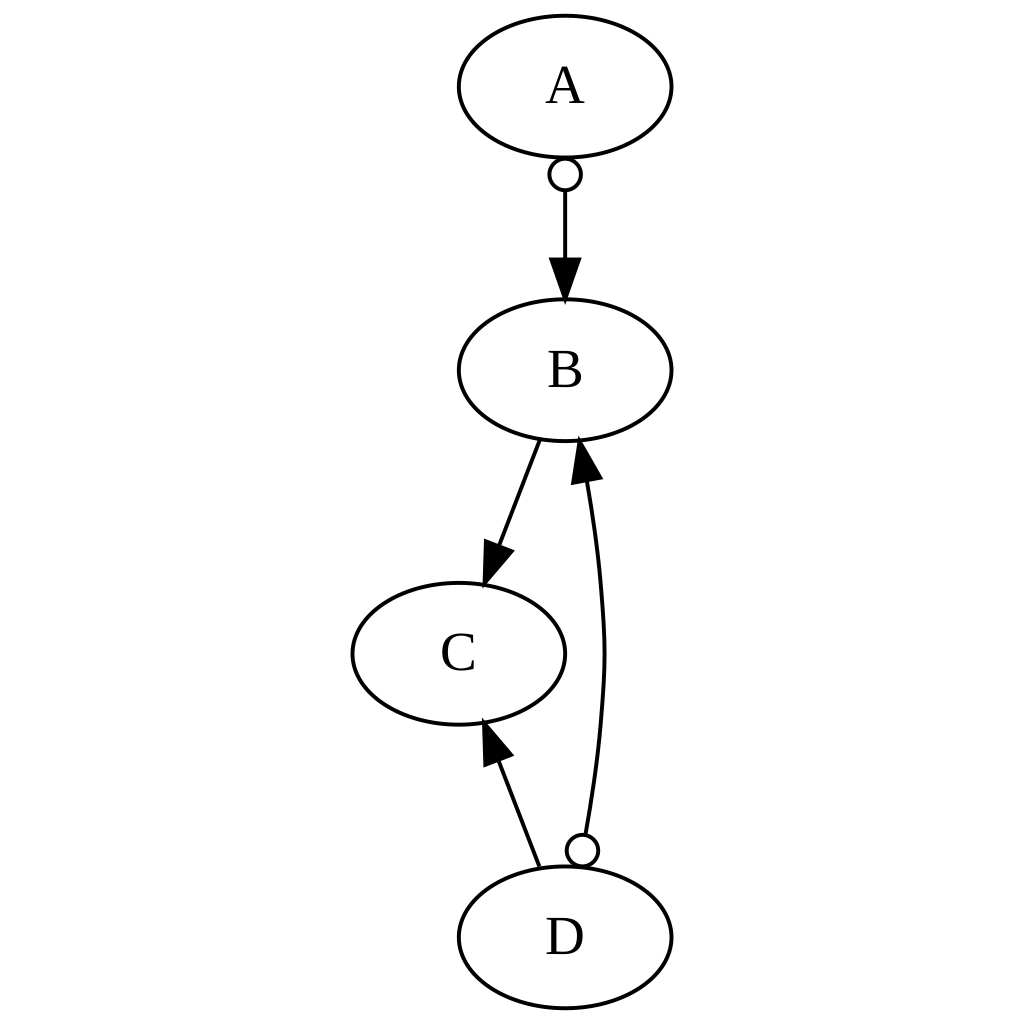

In [18]:
from IPython.display import Image
Image('tmp/estimatedPAG.png', width=400, height=400)

### Questions:

1.  Did we recover the correct PAG?
2.  What the inferred PAG tell us about the relationship between every pair of nodes?
3.  Is the true causal diagram a member of the PAG's Markov Equivalence Class?
4.  What can it happen with a smaller sample size?


##**Part IV: Causal Effect Identification**

### Effect Identification given a Causal Diagram


#### Identification via Adjustment given a Causal Diagram

Checking identifiability of P(y\|do(x)) through generalized adjustment criterion (GAC).

In [19]:
%%R

x = 2 # index of variable "B"
y = 3 # index of variable "C"

trueMAG <- dagitty::toMAG(trueDAG) # graphical model without the latent confounders
                                   # we will see this later

trueMAG.pcalg <- dagitty2amat(trueMAG, type="mag")
labels <- colnames(trueMAG.pcalg)

adj <- pcalg::adjustment(amat = trueMAG.pcalg, amat.type = "mag",
                  x = x, y = y, set.type = "all")
if (length(adj) > 1) {
  print(paste0("P(", labels[y], "|do(", labels[x], ")) is identifiable via adjustment over:"))
  sapply(adj, function(x) { paste(labels[x], collapse=",") } ) # List of all sets admissible for adjustment
} else {
  print(paste0("P(", y, "|do(", x, ")) is not identifiable via adjustment."))
}



[1] "P(C|do(B)) is identifiable via adjustment over:"
[1] "D"   "A,D"


Checking whether a particular set is admissible for adjustment.

In [20]:
%%R

z <- c(1) # indices of the covariate set
zlabels <- labels[z]
print(paste0("Is the effect of ", labels[x], " on ", labels[y], " identifiable through adjustment over {", paste(zlabels, collapse=","), "}? "))


[1] "Is the effect of B on C identifiable through adjustment over {A}? "


In [21]:
%%R

gac_out <- pcalg::gac(trueMAG.pcalg, x, y, z, type = "mag")
is_admissible <- gac_out$gac

print(paste0("Answer: ", is_admissible))

[1] "Answer: FALSE"


#### Identification via ID Algorithm given a Causal Diagram


##### Marginal Causal Effect

In [22]:
%%R

y = "C"
x = "B" # Change to "D" to evaluate the effect of D on C

print(paste0("The marginal effect of ", x, " on ", y, ", P(", y, "|do(", x, ")), is identifiable via ID algorithm:"))

exprDAG <- causaleffect::causal.effect(y=y, x=x, z=c(),
                                       G = trueDiagram,
                                       expr = TRUE,
                                       simp = TRUE,
                                       steps = FALSE)
print(paste0("P(", y, "|do(", x, ")) = ", exprDAG))
# Note: to see all steps applied by the ID algorithm,
# use expr = FALSE and steps = TRUE.

[1] "The marginal effect of B on C, P(C|do(B)), is identifiable via ID algorithm:"
[1] "P(C|do(B)) = \\sum_{D}P(C|D,B)P(D)"


##### Conditional Causal Effect


In [23]:
%%R

y = "C"
x = "B"
z = c("D")

print(paste0("The conditional effect of ", x, " on ", y, " conditional on ", z, ", P(", y, "|do(", x, "), ", z, "), is identifiable via ID algorithm:"))

exprDAG <- causaleffect::causal.effect(y=y, x=x, z=z,
                                       G = trueDiagram,
                                       expr = TRUE,
                                       simp = TRUE,
                                       steps = FALSE)
print(paste0("P(", y, "|do(", x, "), ", z, ") = ", exprDAG))

[1] "The conditional effect of B on C conditional on D, P(C|do(B), D), is identifiable via ID algorithm:"
[1] "P(C|do(B), D) = P(C|D,B)"


### **Questions:**

1. Is the causal effect of D on C identifiable from the causal diagram? If so, how?
2. What can we do if no knowledge is available to construct a causal diagram?



### Effect Identification from the Markov Equivalence Class



#### Using the Generalized Adjustment Criterion (GAC)

Checking identifiability of P(y\|do(x)) through generalized adjustment criterion (GAC).

In [24]:
%%R

labels <- colnames(estPAG@amat)
x = 2 # index of variable "B"
y = 3 # index of variable "C"

adj <- adjustment(amat = estPAG@amat, amat.type = "pag",
                  x = x, y = y, set.type = "all")

if (length(adj) > 1) {
  print(paste0("P(", labels[y], "|do(", labels[x], ")) is identifiable via adjustment over:"))
  sapply(adj, function(x) { paste(labels[x], collapse=",") } ) # List of all sets admissible for adjustment
} else {
  print(paste0("P(", labels[y], "|do(", labels[x], ")) is not identifiable via adjustment."))
}


[1] "P(C|do(B)) is identifiable via adjustment over:"
[1] "D"   "A,D"


Checking whether a particular set is admissible for adjustment.

In [25]:
%%R

z <- c(1) # indices of the covariate set c("A" "B" "C" "D")
zlabels <- labels[z]
print(paste0("Is the effect of ", labels[x], " on ", labels[y], " identifiable through adjustment over {", paste(zlabels, collapse=","), "}? "))


[1] "Is the effect of B on C identifiable through adjustment over {A}? "


In [26]:
%%R

gac_out <- gac(estPAG@amat, x, y, z, type = "pag")
is_admissible <- gac_out$gac

print(paste0("Answer: ", is_admissible))

[1] "Answer: FALSE"


#### Effect Identification via CIDP Algorithm


In [27]:
%%R

if (!require(PAGId)) {
  library(devtools, warn.conflicts=F, quietly=T)
  devtools::install_github("adele/PAGId", dependencies=TRUE)
}

library(PAGId)

#### Marginal Causal Effect

In [28]:
%%R

y = "C"
x = "B"
z = c()

retPAG <- CIDP(estPAG@amat, x, y, z, verbose = FALSE)

print(paste0("Is P(", y, "|do(", x, ")) identifiable? ", retPAG$id))
if (retPAG$id) {
  print(paste0("P(", y, "|do(", x, ")) = ", retPAG$Qexpr[[retPAG$query]]))
}

[1] "Is P(C|do(B)) identifiable? TRUE"
[1] "P(C|do(B)) = \\sum_{D}\\frac{P_{B}(A,C,D)}{P_{B}(A | C,D)}"


In [29]:
%%R

# This shows the steps taken by the CIDP algorithm
# By substitution and simplication, we will get the same adjustment formula
 print(retPAG$Qexpr)

$B
[1] "\\frac{P(A,B,C,D)}{P(B | A,D)}"

$`A,B`
[1] "\\frac{P_{B}(A,C,D)}{P_{B}(A | C,D)}"

$`P_{B}(C)`
[1] "\\sum_{D}\\frac{P_{B}(A,C,D)}{P_{B}(A | C,D)}"



Note: IDP does not simiplifies the expression by leveraging conditional independences. By doing so, we would see the equivalence with the usual adjustment formula.



#### Conditional Causal Effect

In [30]:
%%R

y = "C"
x = "B"
z = c("A")

retPAG <- CIDP(estPAG@amat, x, y, z, verbose = FALSE)

print(paste0("Is P(", y, "|do(", x, "), ", z, ") identifiable? ", retPAG$id))
if (retPAG$id) {
  print(paste0("P(", y, "|do(", x, "), ", z, ") = ", retPAG$Qexpr[[retPAG$query]]))
}

[1] "Is P(C|do(B), A) identifiable? TRUE"
[1] "P(C|do(B), A) = \\frac{P_{B,A}(C)}{\\sum_{C}P_{B,A}(C)}"


In [31]:
%%R

# This shows the steps taken by the CIDP algorithm
# By substitution and simplication, we will get the same adjustment formula
print(retPAG$Qexpr)

$B
[1] "\\frac{P(A,B,C,D)}{P(B | A,D)}"

$`A,B`
[1] "\\frac{P_{B}(A,C,D)}{P_{B}(A | C,D)}"

$`P_{B,A}(C)`
[1] "\\sum_{D}\\frac{P_{B}(A,C,D)}{P_{B}(A | C,D)}"

$`P_{B}(C | A)`
[1] "\\frac{P_{B,A}(C)}{\\sum_{C}P_{B,A}(C)}"



### Questions:

1.  Is the causal effect of D on C identifiable from the PAG? If so, how?